In [303]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Jan Hakenberg(jan.hakenberg@gmail.com)                         #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

# TODO(Adithya): Add comments

from __future__ import print_function
import numpy as np
import pickle

BOARD_ROWS = 3
BOARD_COLS = 3
BOARD_SIZE = BOARD_ROWS * BOARD_COLS

class State:
    def __init__(self, toPlay=1):
        # the board is represented by a n * n array,
        # 1 represents chessman of the player who moves first,
        # -1 represents chessman of another player
        # 0 represents empty position
        self.data = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.winner = None
        self.hashVal = None
        self.end = None
        self.toPlay = toPlay
    # calculate the hash value for one state, it's unique
    def getHash(self):
        if self.hashVal is None:
            self.hashVal = 0
            for i in self.data.reshape(BOARD_ROWS * BOARD_COLS):
                if i == -1:
                    i = 2
                self.hashVal = self.hashVal * 3 + i
            if (self.toPlay == 1):
                self.hashVal = self.hashVal * 3 + 1
            else:
                self.hashVal = self.hashVal * 3 + 2
        return int(self.hashVal)

    # determine whether a player has won the game, or it's a tie
    def isEnd(self):
        if self.end is not None:
            return self.end
        results = []
        # check row
        for i in range(0, BOARD_ROWS):
            results.append(np.sum(self.data[i, :]))
        # check columns
        for i in range(0, BOARD_COLS):
            results.append(np.sum(self.data[:, i]))

        # check diagonals
        results.append(0)
        for i in range(0, BOARD_ROWS):
            results[-1] += self.data[i, i]
        results.append(0)
        for i in range(0, BOARD_ROWS):
            results[-1] += self.data[i, BOARD_ROWS - 1 - i]

        for result in results:
            if result == 3:
                self.winner = 1
                self.end = True
                return self.end
            if result == -3:
                self.winner = -1
                self.end = True
                return self.end

        # whether it's a tie
        sum = np.sum(np.abs(self.data))
        if sum == BOARD_ROWS * BOARD_COLS:
            self.winner = 0
            self.end = True
            return self.end

        # game is still going on
        self.end = False
        return self.end

    # @symbol 1 or -1
    # put chessman symbol in position (i, j)
    def nextState(self, i, j, symbol):
        newState = State(-symbol)
        newState.data = np.copy(self.data)
        newState.data[i, j] = symbol
        return newState

    # print the board
    def show(self):
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.data[i, j] == 1:
                    token = '*'
                if self.data[i, j] == 0:
                    token = '0'
                if self.data[i, j] == -1:
                    token = 'x'
                out += token + ' | '
            print(out)
        print('-------------')

def getAllStatesImpl(currentState, currentSymbol, allStates):
    for i in range(0, BOARD_ROWS):
        for j in range(0, BOARD_COLS):
            if currentState.data[i][j] == 0:
                newState = currentState.nextState(i, j, currentSymbol)
                newHash = newState.getHash()
                if newHash not in allStates.keys():
                    isEnd = newState.isEnd()
                    allStates[newHash] = (newState, isEnd)
                    if not isEnd:
                        getAllStatesImpl(newState, -currentSymbol, allStates)

def getAllStates():
    allStates = dict()
    currentState = State(toPlay=1)
    allStates[currentState.getHash()] = (currentState, currentState.isEnd())
    getAllStatesImpl(currentState, currentState.toPlay, allStates)
    currentState = State(toPlay=-1)
    getAllStatesImpl(currentState, currentState.toPlay, allStates)
    return allStates

# Does not check for validity of the insertion!
def NextState(currState, i, j, symbol):
    newState = State(-symbol)
    newState.data = np.copy(currState.data)
    newState.data[i, j] = symbol
    return newState
    
# all possible board configurations
allStates = getAllStates()


In [302]:
state = State(1)
state.data[0][0] = -1
state.data[0][1] = 1
state.data[1][0] = -1
print(state.getHash())
print(state.isEnd())
print(allStates[state.getHash()])
print(len(allStates)*1)

47386
False
(<__main__.State instance at 0x11666f320>, False)
10955


In [526]:
def combineAndUpdateVaules(p1, p2):
    estimations = p1.estimations
    for key in estimations.keys():
        mean = (p1.estimations[key] + p2.estimations[key])/2
        p1.estimations[key] = mean
        p2.estimations[key] = mean

class Judger:
    # @player1: player who will move first, its chessman will be 1
    # @player2: another player with chessman -1
    # @feedback: if True, both players will receive rewards when game is end
    def __init__(self, player1, player2, feedback=True, shuffleFirstPlayer=False):
        self.p1 = player1
        self.p1.playerID = 1
        self.p2 = player2
        self.p2.playerID = 2
        self.feedback = feedback
        self.currentPlayer = None
        self.p1Symbol = 1
        self.p2Symbol = -1
        self.p1.setSymbol(self.p1Symbol)
        self.p2.setSymbol(self.p2Symbol)
        # Player 1 goes first in the first game, then they alternate.
        self.currentState = State(toPlay=1)
        self.allStates = allStates
        self.startPlayer = 1
        self.shuffleFirstPlayer = shuffleFirstPlayer
    # give reward to two players
    def giveReward(self):
        if self.currentState.winner == self.p1Symbol:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif self.currentState.winner == self.p2Symbol:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.5)
            self.p2.feedReward(0.5)

    def reset(self):
        self.p1.reset()
        self.p2.reset()
        if self.shuffleFirstPlayer:
            self.startPlayer = -self.startPlayer
        if self.startPlayer == 1:
            self.currentState = State(toPlay=1)
            self.currentPlayer = None
        else:
            self.currentState = State(toPlay=-1)
            self.currentPlayer = None

    # @show: if True, print each board during the game
    def play(self, show=False):
#         self.reset()
        while True:
            # set current player
            if self.currentPlayer == self.p1:
                self.currentPlayer = self.p2
            elif self.currentPlayer == self.p2:
                self.currentPlayer = self.p1
            elif self.startPlayer == 1: # game starting case
#                 print("Game starting with player 1...")
                self.currentPlayer = self.p1
            else:
#                 print("Game starting with player 2...")
                self.currentPlayer = self.p2

            if show:
                self.currentState.show()
            # Current player plays a move.
            nextState, isExploratory = self.currentPlayer.takeAction(self.currentState)
            self.currentPlayer.addStateToFeedbackPath(nextState, isExploratory)

            self.currentState = nextState
            hashValue = self.currentState.getHash()
            self.currentState, isEnd = self.allStates[hashValue]
            if isEnd:
                if self.feedback:
                    self.giveReward()
                return self.currentState.winner


In [527]:
import math
# AI player
class Player:
    # @stepSize: step size to update estimations
    # @exploreRate: possibility to explore
    def __init__(self, stepSize = 0.1, exploreRate=0.03, applyExplorationUpdates = False):
        self.allStates = allStates
        self.estimations = dict()
        self.stepSize = stepSize
        self.epoch = 0.0
        self.exploreRate = exploreRate
        self.states = []
        self.exploratoryStates = []
        self.id = 0
        self.applyExplorationUpdates = applyExplorationUpdates

    def savePolicy(self):
        fw = open('optimal_policy_' + str(self.symbol), 'wb')
        pickle.dump(self.estimations, fw)
        fw.close()

    def loadPolicy(self):
        fr = open('optimal_policy_' + str(self.symbol),'rb')
        self.estimations = pickle.load(fr)
        fr.close()

    def reset(self):
        self.states = []

    def updateInitialEstimates(self):
        #Set our initial value estimates for all states.
        for hash in self.allStates.keys():
            (state, isEnd) = self.allStates[hash]
            if isEnd:
                if state.winner == self.symbol:
                    self.estimations[hash] = 1.0
                else:
                    self.estimations[hash] = 0
            else:
                self.estimations[hash] = 0.5
 
    # symbol can only be -1, or 1.
    def setSymbol(self, symbol):
        self.symbol = symbol
        self.updateInitialEstimates()

    # update estimation according to reward
    def feedReward(self, reward):
        if len(self.states) == 0:
            return
        self.epoch += 1.0
        self.states = [state.getHash() for state in self.states]
        target = reward
        self.exploratoryStates.reverse()
        for index, latestState in enumerate(reversed(self.states)):
            if (not self.exploratoryStates[index]) or (self.applyExplorationUpdates):
#                 math.sqrt(self.epoch)
                value = self.estimations[latestState] + (self.stepSize) * (target - self.estimations[latestState])
                self.estimations[latestState] = value
                target = value
        self.states = []
        self.exploratoryStates = []
        

    # determines next action from a state and returns the state resulting from taking that action as well as whether
    # the state taken was exploratory.
    def takeAction(self, state):
        nextStates = []
        nextPositions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if state.data[i, j] == 0:
                    nextPositions.append([i, j])
                    nextStates.append(state.nextState(i, j, self.symbol).getHash())
        if np.random.binomial(1, self.exploreRate):
            np.random.shuffle(nextPositions)
            action = nextPositions[0]
            action.append(self.symbol)
            nextstate = NextState(state, action[0], action[1], self.symbol)
            return nextstate, True
        
        values = []
        for hash, pos in zip(nextStates, nextPositions):
            values.append((self.estimations[hash], pos))
        np.random.shuffle(values)
        values.sort(key=lambda x: x[0], reverse=True)
        action = values[0][1]
        action.append(self.symbol)
        nextState = NextState(state, action[0], action[1], self.symbol)
        return nextState, False

    def addStateToFeedbackPath(self, state, isExploratory):
        self.states.append(state)
        self.exploratoryStates.append(isExploratory)


Epoch: 99000 , P1 win rate(train): 0.072 , P2 win rate(train): 0.067
P1 win rate(train):  0.10644
P2 win rate(train):  0.1154


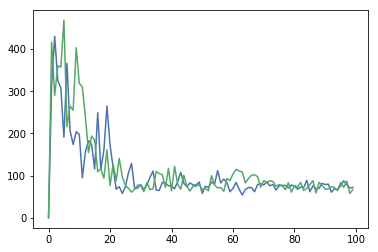

In [529]:
import matplotlib.pyplot as plt
def train(epochs=10000):
    player1 = Player(stepSize=0.01, exploreRate=0.05, applyExplorationUpdates = False)
    player2 = Player(stepSize=0.01, exploreRate=0.05, applyExplorationUpdates = False)
    judger = Judger(player1, player2, shuffleFirstPlayer = True)
    player1Win = 0.0
    player2Win = 0.0
    player1WinPrev = 0.0
    player2WinPrev = 0.0
    gamesWonP1Per1000 = []
    gamesWonP2Per1000 = []
    for i in range(0, epochs):
        winner = judger.play()
        if winner == 1:
            player1Win += 1
        if winner == -1:
            player2Win += 1
        judger.reset()
        if not (i%1000):
            gamesWonP1Per1000.append(player1Win-player1WinPrev)
            gamesWonP2Per1000.append(player2Win-player2WinPrev)
            print('Epoch: {0}'.format(i), 
                  ", P1 win rate(train): {0}".format((player1Win-player1WinPrev) / 1000),
                  ", P2 win rate(train): {0}".format((player2Win-player2WinPrev) / 1000),
                  end="\r"),
            player1WinPrev = player1Win
            player2WinPrev = player2Win
    print()
    print("P1 win rate(train): ", player1Win / epochs)
    print("P2 win rate(train): ", player2Win / epochs)
    player1.savePolicy()
    player2.savePolicy()
    return gamesWonP1Per1000, gamesWonP2Per1000 
    
gamesWonP1Per1000, gamesWonP2Per1000 = train(100000)
plt.plot(gamesWonP1Per1000)
plt.plot(gamesWonP2Per1000)
plt.show()
###
# TIC TAC TOE facts:
###
# If both players play the game randomly, the prob. that first player wins is 0.58, second wins is 0.28
# Sources: http://people.missouristate.edu/lesreid/sol10_04.html
# If the first player plays optimally, and second randomly then, the prob that the first player wins is 0.98,
# second wins is 0.0
# If the first player plays randomly, and second optimally then, the prob that the first player wins is 0.0,
# second wins is ~0.80
# Sources: 
# https://blog.ostermiller.org/tic-tac-toe-strategy
    

In [539]:
def compete(turns=500):
    player1 = Player(exploreRate=0)
    player2 = Player(exploreRate=1)
    judger = Judger(player1, player2, feedback=False, shuffleFirstPlayer=False)
    player1.loadPolicy()
    player2.loadPolicy()
    player1Win = 0.0
    player2Win = 0.0
    for i in range(0, turns):
        if not i%100:
            print('Epoch: {0}'.format(i), end="\r")
        winner = judger.play()
        if winner == 1:
            player1Win += 1
        if winner == -1:
            player2Win += 1
#         input('')
#         judger.currentState.show()
        judger.reset()
    print("P1 win rate(compete): ", player1Win / turns)
    print("P2 win rate(compete): ", player2Win / turns)

compete(1000)

P1 win rate(compete):  0.017
P2 win rate(compete):  0.904


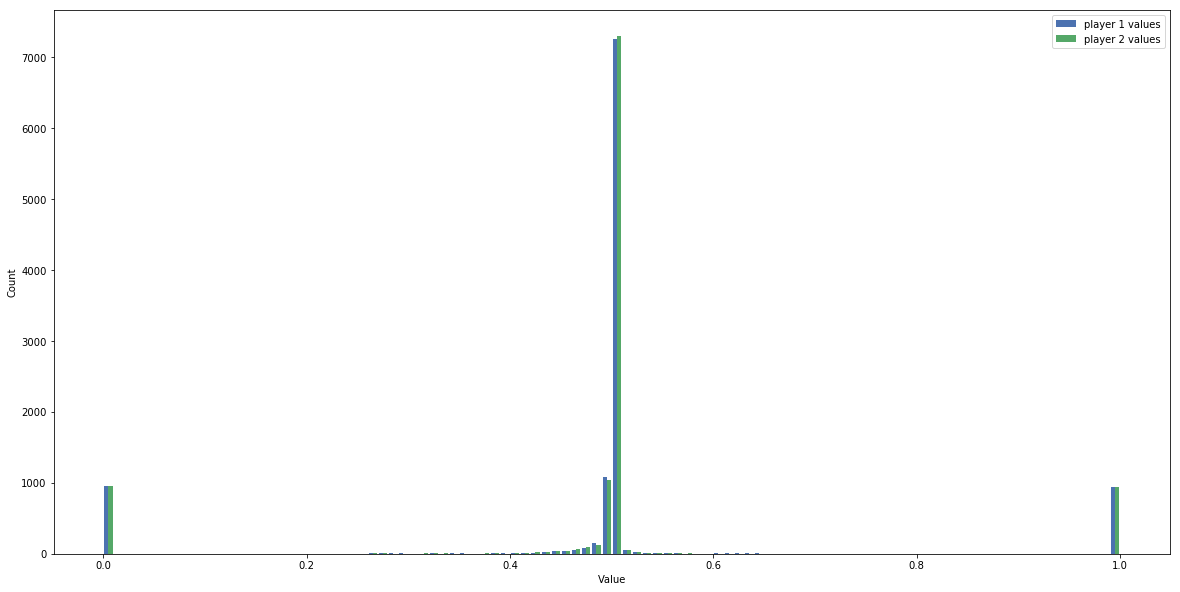

In [482]:
import matplotlib.pyplot as plt
# plt.style.use('seaborn-deep')
player1 = Player(exploreRate=0)
player2 = Player(exploreRate=0)
judger = Judger(player1, player2, False)
player1.loadPolicy()
player2.loadPolicy()

plt.figure(figsize=[20,10])
plt.hist([player1.estimations.values(), player2.estimations.values()],
         bins=100, label = ['player 1 values', 'player 2 values'])
plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('Value')
plt.show()